# Import DataSets

In [1]:
import torch,os
from torchvision import datasets, transforms
from torch.utils.data import random_split, ConcatDataset, DataLoader


# Image transformations
transform = transforms.Compose([
    transforms.Resize((64,64)),  # Resizes the image to 64x64
    transforms.ToTensor(),  # Converts the image into a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes the tensors (mean and std deviation for 3 color channels)
])


transform_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.RandomResizedCrop(64),  # Randomly crop and resize the image to 64x64
    transforms.ToTensor(),  # Converts the image into a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes the tensors (mean and std deviation for 3 color channels)
])


def target_transform_cifar(target):
    # All no dogs images are label 0
    return torch.tensor(0)

def target_transform_dogs(target):
    # All dog images are label 1
    return torch.tensor(1)


# Loading Stanford Dogs dataset with different transformations for training and validation sets
dogs_train = datasets.ImageFolder('./dataset/dogs/images', transform=transform_augmentation, target_transform=target_transform_dogs)
dogs_val = datasets.ImageFolder('./dataset/dogs/images', transform=transform, target_transform=target_transform_dogs)

# Split the dataset into training and validation sets
dog_train, _ = random_split(dogs_train, [3000, len(dogs_train)-3000])
dog_val, _ = random_split(dogs_val, [1000, len(dogs_val)-1000])

# Loading CIFAR-100 dataset
data_dir = './dataset/no_dogs/images/'
# Download and load CIFAR-100 dataset
cifar_dataset_train = datasets.CIFAR100(root=data_dir, download=True, transform=transform_augmentation, target_transform=target_transform_cifar)
cifar_dataset_test = datasets.CIFAR100(root=data_dir, download=True, transform=transform, target_transform=target_transform_cifar)

train_dataset = torch.utils.data.ConcatDataset([dog_train, cifar_dataset_train])
test_dataset = torch.utils.data.ConcatDataset([dog_val, cifar_dataset_test])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Stage 2: Building the convolutional neural network model

In PyTorch, we create a class for our model that inherits from nn.Module. Within this class, we define the layers of our network in the __init__ method and specify how data is propagated through the network in the forward method.

Here is the code for a simple CNN with two convolutional layers, followed by pooling layers, and two fully connected layers at the end.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer: input channels = 3 (RGB), output channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer: input channels = 32 (from previous layer), output channels = 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Pooling layer: we'll use this after each convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        # Fully connected layers: to classify the features extracted by the convolutional layers
        self.fc1 = nn.Linear(64 * 16 * 16, 500)
        self.fc2 = nn.Linear(500, 2)  # 2 output classes: cat and dog

    def forward(self, x):
        # Apply first conv layer, followed by ReLU, then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second conv layer, followed by ReLU, then max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the tensor output from the conv layers
        x = x.view(-1, 64 * 16 * 16)
        # Apply dropout after activation function
        x = F.relu(self.fc1(self.dropout(x)))  
        x = self.fc2(self.dropout(x))
        return x


# Stage 3: Train model

For this, we need to define a loss function and an optimiser. We will use Cross Entropy as our loss function, as it is a good choice for classification problems. For the optimiser, we will use Adam.

Furthermore, we will divide our dataset into a training set and a validation set. During each epoch, we will train the model on the training set and then evaluate it on the validation set. If the performance on the validation set improves, we will save the model.

In [3]:
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch

# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("It is using: " + device.type)

# Initialize the network
model = Net().to(device)

# Path to save the model
model_path = 'best_model.pth'
if os.path.exists(model_path):
    print("El modelo existe.")
    model = Net()
    model.load_state_dict(torch.load(model_path))
    if torch.cuda.is_available():
        print("Usando cuda")
        model = model.to('cuda')
else:
    print("El modelo no existe.")
    model = Net()
    if torch.cuda.is_available():
        print("Usando cuda")
        model = model.to('cuda')

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Define a number of training epochs
epochs = 10

#actually is my best
best_loss = 50

best_val_loss = float('inf')  # Initialize with a high value

# Training loop
for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    
    # Create a progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    
    for inputs, labels in progress_bar:
        # Move data to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'training_loss': loss.item()})

    # Set the model to evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move data to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update the validation loss
            val_loss += loss.item()

    # Print epoch loss
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}')

    # Save the model if it has the best validation loss so far
    print(f'El loss actual es {val_loss} y el mejor es {best_val_loss}')
    if val_loss < best_val_loss:
        print("model saved")
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

print('Finished Training')



It is using: cuda
El modelo existe.
Usando cuda


Epoch 1:   0%|          | 0/829 [00:06<?, ?it/s]


KeyboardInterrupt: 

# Stage 4: Predict images

The next step after training is to evaluate the performance of the model on a test set. However, in this case, the labels of the test set are not available because you are supposed to send your predictions to Kaggle for evaluation. Therefore, instead, we can use some of the validation images to demonstrate how to make predictions with the model. This code loads the model we saved during training, puts it in evaluation mode (which disables Dropout, among other things), gets a batch of validation data, makes predictions for that batch, and then prints the predicted and true labels.

In [4]:
# Load the saved model
model = Net().to(device)
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Get a batch of validation data
inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(inputs)

probabilities = F.softmax(outputs, dim=1)

# The outputs are probabilities for each class. To get the predicted class, we take the index of the highest probability.
_, preds = torch.max(probabilities, 1)

# Print the predicted and true labels
print('Predicted:', preds)
print('True:     ', labels)


Predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True:      tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


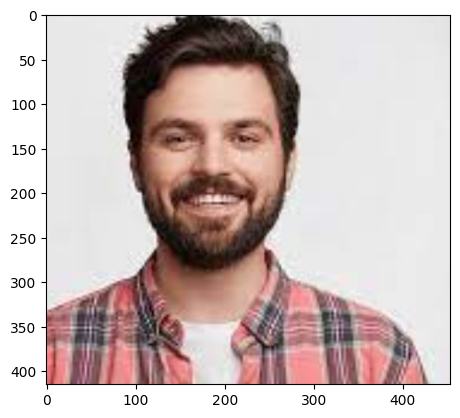

tensor([[0.5018, 0.4982]], device='cuda:0')
no dog


In [5]:
from PIL import Image

def predict_image(model, image_path):
    """Predict the class of an image with a trained model."""
    
    # Set the model to evaluation mode
    model.eval()

    # Open the image
    image = Image.open(image_path)

    # Define the same transformation as before
    trans = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

    # Apply the transformation and add an extra dimension for the batch
    image = trans(image).unsqueeze(0).to(device)

    # Make the prediction
    # Make the prediction
    with torch.no_grad():
        output = model(image)

    # Apply softmax to get probabilities
    probabilities = F.softmax(output, dim=1)  # Changed 'outputs' to 'output'

    # Print the output
    print(probabilities)  # Changed 'output' to 'probabilities' to print the probabilities

    # Get the predicted class
    _, predicted = torch.max(probabilities, 1)

    return 'dog' if predicted.item() == 1 else 'no dog'



from PIL import Image
import matplotlib.pyplot as plt

# Open the image
image_path = './dataset/Captura de pantalla 2023-07-18 133051.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.show()

# Load the saved model
model = Net().to(device)
model.load_state_dict(torch.load('best_model.pth'))

# Predict the class of an image
print(predict_image(model, image_path))

In [7]:
from flask import Flask, request, jsonify
from werkzeug.exceptions import BadRequest
from PIL import Image
from io import BytesIO
from flask_cors import CORS

app = Flask(__name__)
CORS(app)
# Load the saved model
model = Net().to(device)
model.load_state_dict(torch.load('best_model.pth'))

def predict_image(model, image):
    """Predict the class of an image with a trained model."""
    
    # Set the model to evaluation mode
    model.eval()

    # Define the same transformation as before
    trans = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

    # Apply the transformation and add an extra dimension for the batch
    image = trans(image).unsqueeze(0).to(device)

    # Make the prediction
    # Make the prediction
    with torch.no_grad():
        output = model(image)

    # Apply softmax to get probabilities
    probabilities = F.softmax(output, dim=1)  # Changed 'outputs' to 'output'

    # Print the output
    print(probabilities)  # Changed 'output' to 'probabilities' to print the probabilities

    # Get the predicted class
    _, predicted = torch.max(probabilities, 1)

    return 'dog' if predicted.item() == 1 else 'no dog'

@app.route('/predict/dogNet', methods=['POST'])
def predict():
    if 'image' not in request.files:
        raise BadRequest('No image file in the request')
    
    file = request.files['image']
    image = Image.open(BytesIO(file.read()))
    prediction = predict_image(model, image)
    
    result = {
        'prediction': prediction
    }
    return result

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.20:5000
Press CTRL+C to quit
[2023-07-18 15:36:37,122] ERROR in app: Exception on /predict/dogNet [POST]
Traceback (most recent call last):
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask_cors\extension.py", line 176, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
                                                ^^^^^^^^^^^^^^^^^^
  File "c:\Users\carlo\AppData\Local\Programs\Python\Python311\Li